In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr
import pulse2percept.utils as p2pu

import skimage.io as skio
import skimage.transform as skit

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-06-12 13:15:28,219 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
results_dir = '../../results/shape1cv/'
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjectdata['scale'] = pd.Series([0.5, 1.5, 1.0, 0.6], index=subjectdata.index)
subjectdata

,second_sight_id,implant_x,implant_y,implant_rot,loc_od_x,loc_od_y,xrange,yrange,implant_type,scale
subject_id,,,,,,,,,,
S1,TB,-406,-162,-0.698,17.7,1.680,"(-36.9, 36.9)","(-36.9, 36.9)",<class 'pulse2percept.implants.ArgusI'>,0.5
S2,12-005,-1725,-366,-0.474,15.3,0.922,"(-30.0, 30.0)","(-22.5, 22.5)",<class 'pulse2percept.implants.ArgusII'>,1.5
S3,51-009,249,-486,-0.609,15.0,1.790,"(-32.5, 32.5)","(-24.4, 24.4)",<class 'pulse2percept.implants.ArgusII'>,1.0
S4,52-001,-1502,-227,-0.415,16.9,2.500,"(-32.0, 32.0)","(-24.0, 24.0)",<class 'pulse2percept.implants.ArgusII'>,0.6


In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        [row.update(bp) for bp in best_params]
        data.append(row)
    return pd.DataFrame(data)

In [5]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
#         xyrange = np.array([np.diff(subjectdata.loc[subject, 'xrange'])[0],
#                             np.diff(subjectdata.loc[subject, 'yrange'])[0]])
        y_test = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'image': row['image'].values[0],
                                'img_shape': row['image'].values[0].shape,
                                'electrode': row['electrode'].values[0],
                                'area': float(row['area']),# / np.prod(row['image'].values[0].shape) * np.prod(xyrange),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
                            
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.drop(columns=['image', 'img_shape', 'electrode']).columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [6]:
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 392 files


In [7]:
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [8]:
data = load_data(pickle_files, verbose=False)

In [9]:
data = data.loc[np.logical_not(data.model == 'C2'), :]

In [10]:
data.columns

Index(['axlambda', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'rho', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [11]:
# Group by these:
groupcols = ['subject', 'model']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity']
r2cols = ['r2_%s' % name for name in predcols]

In [12]:
data.groupby(groupcols + ['idx_fold'], sort=False).agg({'best_train_cost': ['count', 'mean', 'std'],
                                                        'rho': ['mean', 'std'],
                                                        'axlambda': ['mean', 'std']})

axlambda              best_train_cost              \
                               mean          std           count        mean   
subject model idx_fold                                                         
S1      A     0                 NaN          NaN               3  176.109008   
              1                 NaN          NaN               3  148.149534   
              2                 NaN          NaN               3  306.807340   
              3                 NaN          NaN               3  158.941912   
              4                 NaN          NaN               3  150.090607   
              5                 NaN          NaN               3  146.226372   
              6                 NaN          NaN               3  148.351500   
              7                 NaN          NaN               3  168.346153   
              8                 NaN          NaN               3  143.410650   
              9                 NaN          NaN               3  156.065232   
        C     0         2364.801549   419.484131               5    9.086925   
              1         2080.133830   382.154475               5    5.561622   
              2         2352.690250   345.616696               5    6.856116   
              3         2207.949870   324.938229               5    5.864281   
              4         2419.333573   795.350230               5    5.526420   
              5         2272.290298   395.313436               5    6.043272   
              6         2460.979777   604.321203               5    6.955214   
              7         2087.645409   499.903576               5    7.031689   
              8         2336.875217   526.898422               5    5.941942   
              9         2373.737814   531.687823               5    5.843728   
S2      A     0                 NaN          NaN               2   14.826680   
              1                 NaN          NaN               2   15.594331   
              10                NaN          NaN               1   15.053063   
              11                NaN          NaN               1   15.358640   
              12                NaN          NaN               1   14.465781   
              13                NaN          NaN               1   14.779847   
              14                NaN          NaN               1   14.299176   
              15                NaN          NaN               1   15.974765   
              16                NaN          NaN               1   14.798528   
              17                NaN          NaN               1   22.080497   
...                             ...          ...             ...         ...   
S4      A     16                NaN          NaN               1   21.116576   
              17                NaN          NaN               1   20.626943   
              18                NaN          NaN               1   20.862487   
              2                 NaN          NaN               2   21.365183   
              3                 NaN          NaN               2   22.015501   
              4                 NaN          NaN               1   19.885955   
              5                 NaN          NaN               1   20.360583   
              6                 NaN          NaN               1   20.627194   
              7                 NaN          NaN               1   21.703361   
              8                 NaN          NaN               1   20.212887   
              9                 NaN          NaN               1   21.036802   
        C     0         2321.306538   282.286018               5    4.449543   
              1         1472.519656   967.221739               5    4.800954   
              10        1298.384693   635.979979               5    5.560126   
              11         431.375360    30.218845               5    4.642144   
              12        1066.276695   885.623029               5    4.625282   
              13         89

# The best runs in their respective category

In [13]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])
gb.agg({'best_train_cost': ['count', 'min'], 'rho': 'mean', 'axlambda': 'mean'})

Best scores:


axlambda best_train_cost                     rho
                               mean           count         min        mean
subject model idx_fold                                                     
S1      A     0                 NaN               1  174.740706  459.678237
              1                 NaN               1  144.818625  515.146557
              2                 NaN               1  301.878179  511.682707
              3                 NaN               1  155.063336  511.946741
              4                 NaN               1  141.974382  511.634455
              5                 NaN               1  143.469994  512.619473
              6                 NaN               1  148.201546  512.614117
              7                 NaN               1  165.140639  512.623776
              8                 NaN               1  141.185584  512.620074
              9                 NaN               1  156.065232  511.680618
        C     0         2735.652851               1    8.988158  325.099614
              1         2503.285347               1    5.453661  317.204467
              2         1879.847102               1    6.724565  219.678382
              3         2633.548195               1    5.818401  232.371795
              4         3000.000000               1    5.391106  311.536669
              5         2560.161571               1    5.992426  234.765836
              6         2840.808938               1    6.939133  234.716425
              7         2871.420855               1    7.007276  234.196499
              8         2871.093834               1    5.880647  234.534015
              9         2704.973282               1    5.756206  274.722318
S2      A     0                 NaN               1   14.738361  497.386393
              1                 NaN               1   15.592180  524.339802
              2                 NaN               1   15.050400  510.128267
              3                 NaN               1   15.214308  496.690018
              4                 NaN               1   15.259691  524.336639
              5                 NaN               1   15.354731  574.522025
              6                 NaN               1   14.671961  510.088589
              7                 NaN               1   14.632983  474.347225
              8                 NaN               1   14.989083  510.088084
              9                 NaN               1   14.510667  532.112956
...                             ...             ...         ...         ...
S4      A     8                 NaN               1   20.212887  744.870164
              9                 NaN               1   21.036802  830.301460
              10                NaN               1   30.497382  778.194049
              11                NaN               1   21.161976  936.128567
              12                NaN               1   21.020191  790.846546
              13                NaN               1   21.183289  813.964947
              14                NaN               1   21.430725  659.863944
              15                NaN               1   22.187146  693.422573
              16                NaN               1   21.116576  744.146917
              17                NaN               1   20.626943  729.827593
              18                NaN               1   20.862487  813.968458
        C     0         2498.689209               1    4.385385  503.355784
              1          415.678149               1    4.469040  561.819839
              2          463.644441               1    4.326538  552.391211
              3          573.365219               1    4.458065  544.702195
              4         2570.475727               1    4.682888  397.017443
              5          505.728337               1    4.497260  593.749897
              6          472.503812               1    4.421025  573.895898
              7          440.872838               1    4.533462  572.663577

In [14]:
gb = data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols)
gb.agg({'rho': ['mean', 'std'], 'axlambda': ['mean', 'std']})

axlambda                     rho           
                      mean         std        mean        std
subject model                                                
S1      A              NaN         NaN  507.224675  16.737530
        C      2660.079198  314.318059  261.882602  41.267627
S2      A              NaN         NaN  515.845482  21.037306
        C       286.523781   31.881896  437.212226  44.005119
S3      A              NaN         NaN  172.066230   0.191696
        C       728.672843  682.775900   52.067722   2.973407
S4      A              NaN         NaN  780.626759  61.709722
        C       698.518859  650.786975  538.711078  57.262756

In [15]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,best_test_cost,model,r2_area,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,167.562065,A,-1.928703,-159.843214,-2.790149,S1,area eccentricity electrode \ 0 243.0...,area eccentricity electrode \ 0 248...
1,6.854980,C,-2.048375,-1.376025,-0.430579,S1,area eccentricity electrode \ 32 558.0...,area eccentricity electrode \ 32 248...
2,16.338003,A,-0.097738,-12.333911,-0.906355,S2,area eccentricity electrode \ 81 3054...,area eccentricity electrode \ 81 3437...
3,4.958757,C,-1.325528,-1.046000,0.412771,S2,area eccentricity electrode \ 103 28...,area eccentricity electrode \ 103 34...
4,11592.372535,A,-0.533367,-11585.392382,-3.446786,S3,area eccentricity electrode \ 190 308...,area eccentricity electrode \ 190 4...
5,7.242630,C,-2.547740,-0.779832,-0.915057,S3,area eccentricity electrode \ 213 3...,area eccentricity electrode \ 213 4...
6,20.935537,A,-0.065291,-18.214157,0.343911,S4,area eccentricity electrode \ 275 71...,area eccentricity electrode \ 275 ...
7,5.629677,C,-1.605231,-1.166850,0.142404,S4,area eccentricity electrode \ 301 1...,area eccentricity electrode \ 301 ...


# Plot predictions

In [16]:
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
all_ticks = (([0, 2400], [-90, 90], [0, 1]),
             ([0, 6000], [-90, 90], [0, 1]),
             ([0, 2000], [-90, 90], [0, 1]),
             ([0, 18000], [-90, 90], [0, 1]))
labels = ['area (pixels$^2$)', 'orientation (deg)', 'elongation']

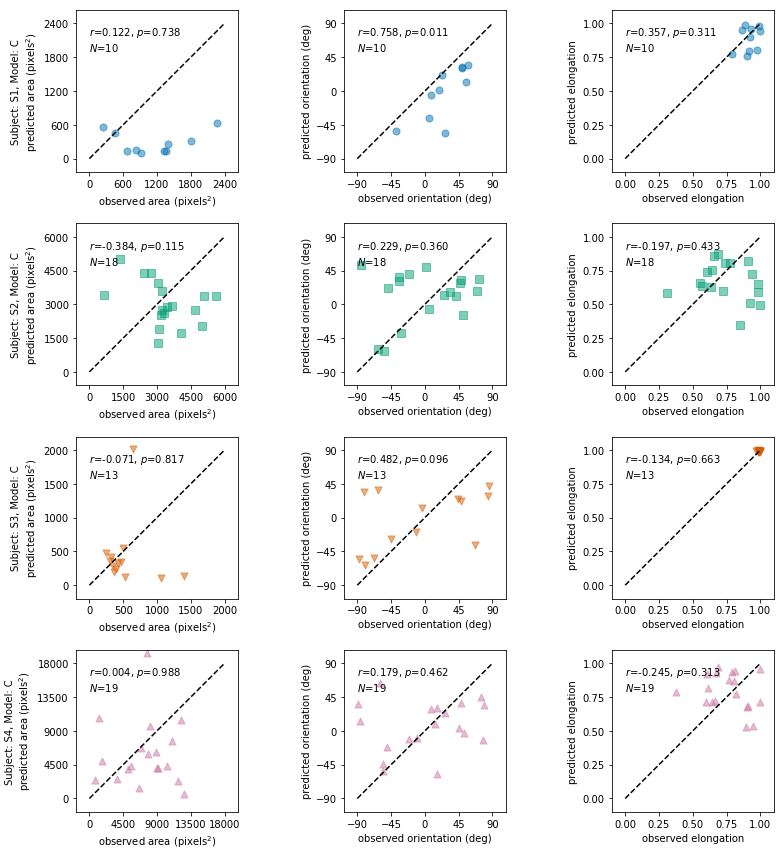

In [17]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(12, 3 * len(subjects)))
for subject, marker, color, ticks, axrow in zip(subjects, markers, colors, all_ticks, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, label in zip(predcols, axrow, ticks, labels):
            lim = [1.1 * tick[0] - 0.1 * tick[1], 1.1 * tick[1] - 0.1 * tick[0]]
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.axis('square')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            if pval >= 0.001:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.3f\n$N$=%d\n" % (rval, pval, len(y)), 
                        va='top', ha='left')
            else:
                ax.text(tick[0], tick[1], "$r$=%.3f, $p$=%.2e\n$N$=%d" % (rval, pval, len(y)), 
                        va='top', ha='left')
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (subject, plotmodel, labels[0]))
fig.tight_layout()
fig.savefig('fig7-scatter-%s.eps' % plotmodel)
fig.savefig('fig7-scatter-%s.png' % plotmodel)

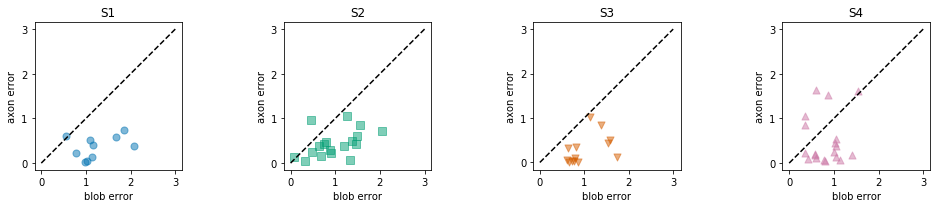

In [18]:
fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 3))
for subject, marker, color, ax in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    errb = 0
    erra = 0
    for col in predcols:
        yb = (best_blob['y_pred'].values[0][col] - best_blob['y_test'].values[0][col]) ** 2
        ya = (best_axon['y_pred'].values[0][col] - best_axon['y_test'].values[0][col]) ** 2
        ymax = np.max([yb.max(), ya.max()])
        errb += yb / ymax
        erra += ya / ymax
    ax.scatter(errb, erra, marker=marker, s=50, c=color, alpha=0.5)
    ax.set_xlabel('blob error')
    ax.set_ylabel('axon error')
    ax.plot([0, 3], [0, 3], 'k--')
    ax.set_xticks(np.linspace(0, 3, 4))
    ax.set_yticks(np.linspace(0, 3, 4))
    ax.axis('square')
    ax.set_title(subject)
fig.tight_layout()

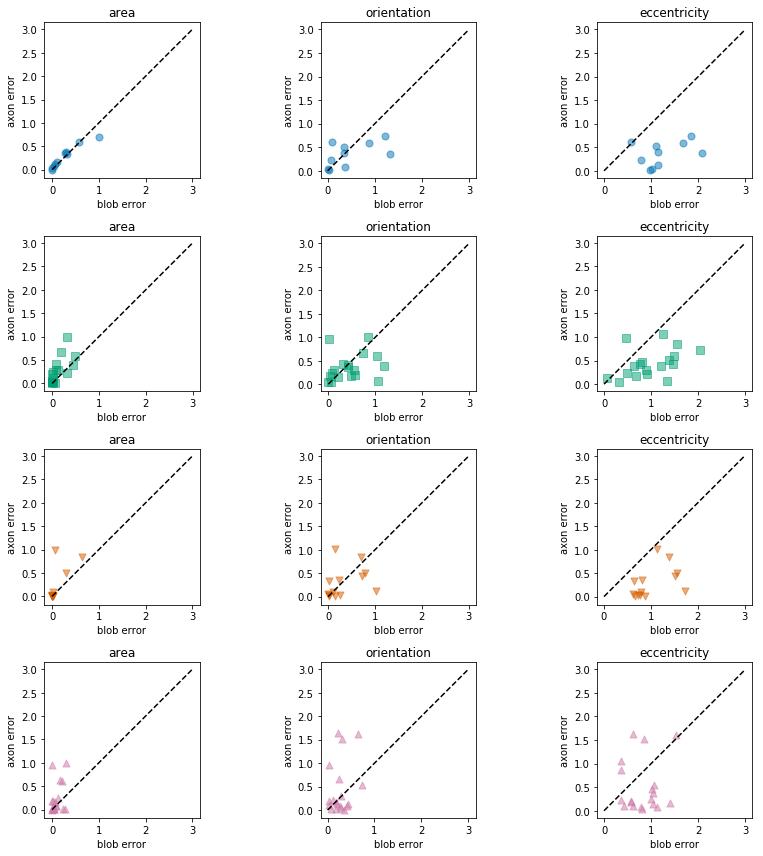

In [19]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=len(predcols), figsize=(12, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    errb = 0
    erra = 0
    for col, ax in zip(predcols, axrow):
        yb = (best_blob['y_pred'].values[0][col] - best_blob['y_test'].values[0][col]) ** 2
        ya = (best_axon['y_pred'].values[0][col] - best_axon['y_test'].values[0][col]) ** 2
        ymax = np.max([yb.max(), ya.max()])
        errb += yb / ymax
        erra += ya / ymax
        ax.scatter(errb, erra, marker=marker, s=50, c=color, alpha=0.5)
        ax.set_xlabel('blob error')
        ax.set_ylabel('axon error')
        ax.plot([0, 3], [0, 3], 'k--')
        ax.axis('square')
        ax.set_title(col)
fig.tight_layout()

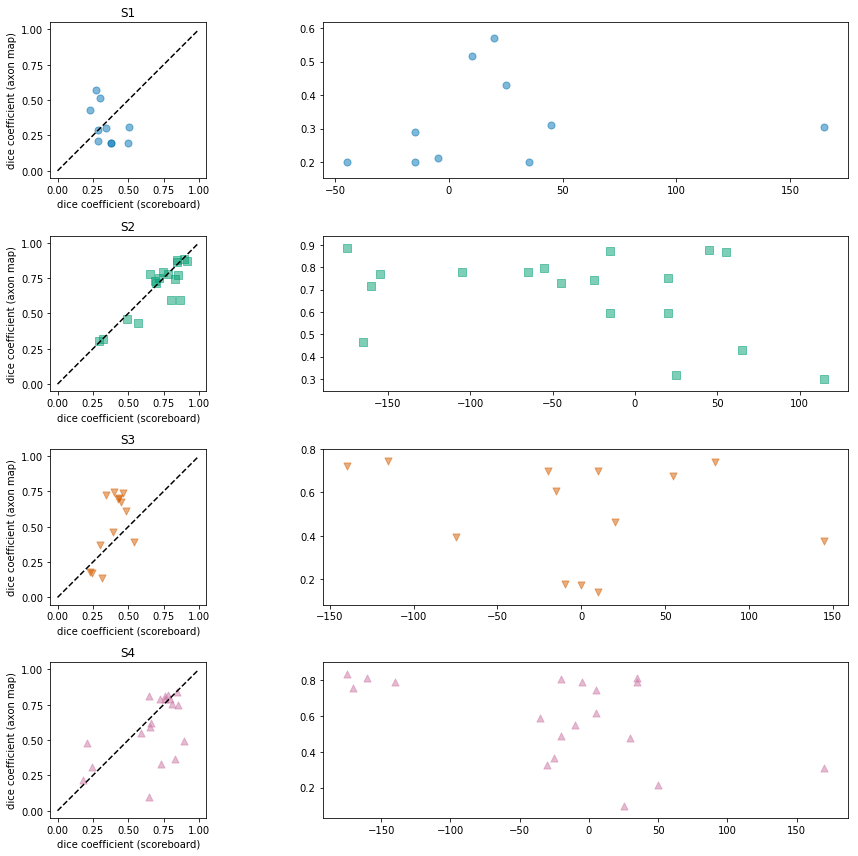

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=len(subjects), figsize=(14, 3 * len(subjects)))
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    best_blob = best[np.logical_and(best['subject'] == subject, best['model'] == 'A')]
    best_axon = best[np.logical_and(best['subject'] == subject, best['model'] == 'C')]
    for (_, fold_b), (_, fold_a) in zip(best_blob.iterrows(), best_axon.iterrows()):
        dice_b = [argus_shapes.imgproc.dice_coeff(argus_shapes.imgproc.center_phosphene(y['image']),
                                                  argus_shapes.imgproc.center_phosphene(yb['image'])) 
                  for (_, y), (_, yb) in zip(fold_b['y_test'].iterrows(), fold_b['y_pred'].iterrows())]
        dice_a = []
        angle_a = []
        for (_, y), (_, ya) in zip(fold_a['y_test'].iterrows(), fold_a['y_pred'].iterrows()):
            _, angle, dice = argus_shapes.imgproc.rd_loss(y['image'], ya['image'], return_all=True)
            dice_a.append(dice)
            angle_a.append(angle)
          
#         dice_a = [argus_shapes.imgproc.dice_coeff(argus_shapes.imgproc.center_phosphene(y['image']), 
#                                                   argus_shapes.imgproc.center_phosphene(ya['image'])) 
#                   for (_, y), (_, ya) in zip(fold_a['y_test'].iterrows(), fold_a['y_pred'].iterrows())]
        axrow[0].plot([0, 1], [0, 1], 'k--')
        axrow[0].scatter(dice_b, dice_a, marker=marker, s=50, c=color, alpha=0.5)
        axrow[0].axis('square')
        axrow[0].set_xticks(np.linspace(0, 1, 5))
        axrow[0].set_yticks(np.linspace(0, 1, 5))
        axrow[0].set_xlabel('dice coefficient (scoreboard)')
        axrow[0].set_ylabel('dice coefficient (axon map)')
        axrow[0].set_title(subject)
        
        axrow[1].scatter(angle_a, dice_a, marker=marker, s=50, c=color, alpha=0.5)
        axrow[1].set_xlabel('rotation angle for axon map')
        axrow[1].set_ylabel('dice coefficient')
fig.tight_layout()

In [21]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [22]:
px_argus1 = np.array([
    [  93.12857037,  162.32202802],
    [ 138.00952276,  163.7029804 ],
    [ 178.74761799,  163.01250421],
    [ 227.77142752,  161.63155183],
    [  93.12857037,  208.58393279],
    [ 143.53333228,  207.8934566 ],
    [ 182.89047514,  207.2029804 ],
    [ 227.77142752,  206.51250421],
    [  93.12857037,  251.3934566 ],
    [ 137.31904657,  251.3934566 ],
    [ 180.81904657,  251.3934566 ],
    [ 227.08095133,  251.3934566 ],
    [  93.81904657,  296.27440898],
    [ 140.08095133,  296.27440898],
    [ 182.89047514,  297.65536136],
    [ 227.08095133,  297.65536136]
])
px_argus1[:, 0] += 70
px_argus1[:, 1] -= 70

px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [23]:
def plot_phosphenes_on_array(ax, subject, Xymu, subjectdata):
    Xymu = Xymu[Xymu.subject == subject]
    implant_type = subjectdata.loc[subject, 'implant_type']
    argus = implant_type(x_center=subjectdata.loc[subject, 'implant_x'],
                         y_center=subjectdata.loc[subject, 'implant_y'],
                         rot=subjectdata.loc[subject, 'implant_rot'])
    is_argus2 = isinstance(implant_type(), p2pi.ArgusII)
    if is_argus2:
        px_argus = px_argus2
        img_argus = img_argus2
    else:
        px_argus = px_argus1
        img_argus = img_argus1    
    
    padding = 2000
    x_range = (p2pr.ret2dva(np.min([e.x_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.x_center for e in argus]) + padding))
    y_range = (p2pr.ret2dva(np.min([e.y_center for e in argus]) - padding),
               p2pr.ret2dva(np.max([e.y_center for e in argus]) + padding))
    out_shape = Xymu.img_shape.unique()[0]  # (np.diff(y_range)[0] * 10, np.diff(x_range)[0] * 10)
    pts_in = []
    pts_dva = []
    pts_out = []
    for xy, e in zip(px_argus, argus):
        pts_in.append(xy)
        dva = p2pr.ret2dva([e.x_center, e.y_center])
        pts_dva.append(dva)
        xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
        yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
        pts_out.append([xout, yout])
    argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
    dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
    argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))
    
    # top left, top right, bottom left, bottom right
    pts_draw = [[0, 0], [0, out_shape[1] - 1],
                [out_shape[0] - 1, 0], [out_shape[1] - 1, out_shape[0] - 1]]
    x_range = subjectdata.loc[subject, 'xrange']
    y_range = subjectdata.loc[subject, 'yrange']
    pts_dva = [[x_range[0], y_range[0]], [x_range[0], y_range[1]],
               [x_range[1], y_range[0]], [x_range[1], y_range[1]]]
    draw2dva = skit.estimate_transform('similarity', np.array(pts_draw), np.array(pts_dva))

    all_imgs = np.zeros(out_shape)
    for _, row in Xymu.iterrows():
        e_pos = p2pr.ret2dva((argus[row['electrode']].x_center, argus[row['electrode']].y_center))
        align_center = dva2out(e_pos)[0]
        img_drawing = argus_shapes.imgproc.scale_phosphene(row['image'], subjectdata.loc[subject, 'scale'])
        img_drawing = argus_shapes.imgproc.center_phosphene(img_drawing, center=align_center[::-1])
        all_imgs += img_drawing
    all_imgs = np.maximum(0, np.minimum(1, 1 - all_imgs))
    ax.imshow(np.ma.masked_where(all_imgs > 0.5, all_imgs), vmin=0, vmax=1, cmap='gray')
    ax.imshow(skit.warp(img_argus, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
    
    fovea = fovea = dva2out([0, 0])[0]
    ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

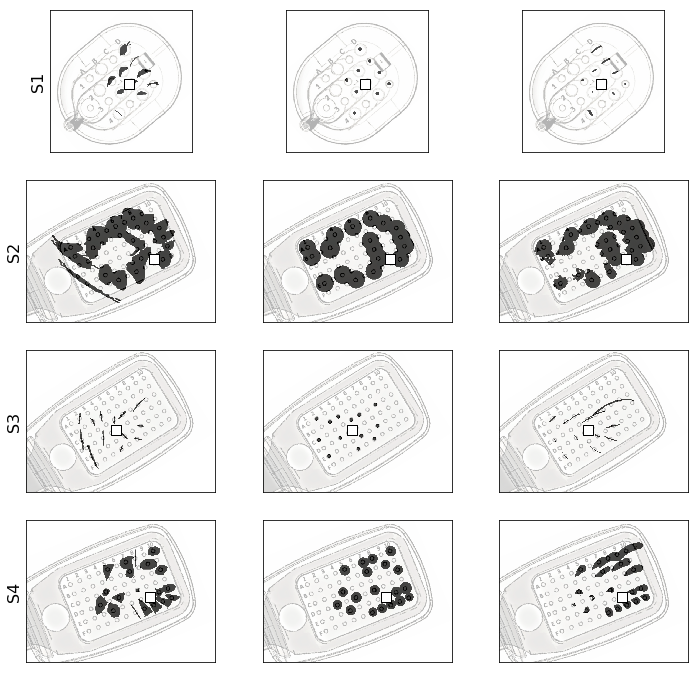

In [24]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=3, figsize=(12, 3 * len(subjects)))
for subject, axrow in zip(subjects, axes):
    for model, col, ax in zip(['A', 'A', 'C'], ['y_test', 'y_pred', 'y_pred'], axrow):
        yp = best[np.logical_and(best['subject'] == subject, best['model'] == model)][col].values[0]
        yp['subject'] = pd.Series([subject for _, _ in yp.iterrows()], index=yp.index)
        plot_phosphenes_on_array(ax, subject, yp, subjectdata)
        ax.set_xticks([])
        ax.set_yticks([])
    axrow[0].set_ylabel(subject, fontsize=16)
fig.savefig('fig7-model-scatter.png')